In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import *
import seaborn as sns
import h5py
from vizman import viz


In [3]:
viz.set_visual_style()
viz_sizes = viz.load_data_from_json("sizes.json")
viz_colors = viz.load_data_from_json("colors.json")
viz_cmaps = viz.give_colormaps()
sns_kwargs = {"cmap": viz_cmaps["bw_lr"],
              "xticklabels":False,
              "yticklabels":False,
              "rasterized":True}

In [4]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/human/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

Text(0.5, 1.0, 'Propagation distance')

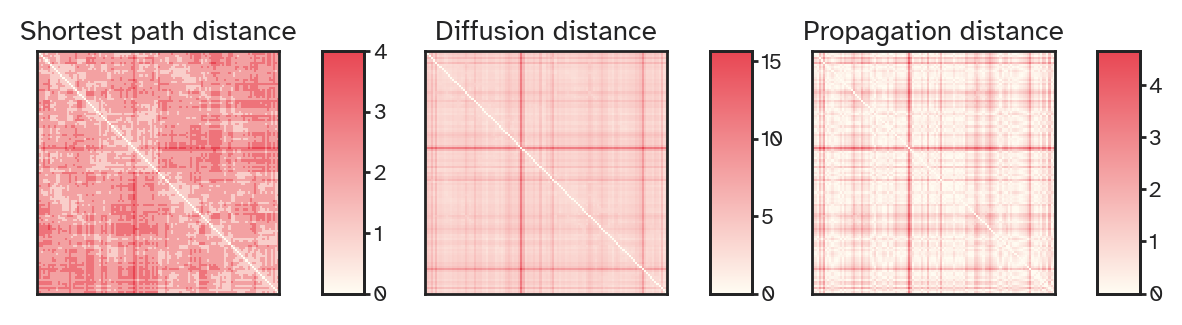

In [169]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"]], 
                               figsize=(viz.cm_to_inch((18,4))),
                               dpi=200)
viz.plot_matrix(gen.shortest_path_distance(connectivity, coordinates),
                cbar=True,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(gen.resistance_distance(connectivity, coordinates), 
                cbar=True, sns_kwargs=sns_kwargs, axis=axes["B"])
viz.plot_matrix(gen.propagation_distance(connectivity), 
                cbar=True, 
                sns_kwargs=sns_kwargs, axis=axes["C"])
axes["A"].set_title("Shortest path distance")
axes["B"].set_title("Diffusion distance")
axes["C"].set_title("Propagation distance")

#plt.savefig("figures/res1_rd_vs_sp_heatmaps.pdf",dpi=600,bbox_inches='tight');

In [135]:
SIMULATE = False
if SIMULATE:
    n_iterations = 10_000
    n_nodes = connectivity.shape[0]
    beta = np.full(n_iterations, 1)
    noise = np.zeros(n_iterations)
    penalty = np.zeros(n_iterations)
    batch_size = np.full(n_iterations, 16)

    start = 1
    stop = 10
    numsteps = stop - start
    params = np.linspace(start, stop, numsteps)
    scores = np.zeros(len(params))
    histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
    densities = np.zeros(len(params))
    for ind, val in enumerate(params):
        alpha = np.full(n_iterations, val)
        histories[...,ind] = gen.simulate_network_evolution(
            coordinates=coordinates,
            n_iterations=n_iterations,
            alpha=alpha,
            beta=np.full(n_iterations, 1),
            noise=noise,
            distance_fn=gen.propagation_distance,
            connectivity_penalty=penalty,
            n_jobs=-1,
            random_seed=11,
            batch_size=batch_size,
        )
        scores[ind] = density_distance(connectivity, histories[:,:,-1,ind])
        densities[ind] = check_density(histories[:,:,-1,ind])
        print(f"Parameter {ind+1}/{len(params)} error: {scores[ind]:.2f}")
    np.save("simulations/pd_alpha08_10k_res1_scores.npy",scores)
    np.save("simulations/pd_alpha08_10k_res1_matrices.npy",histories)
    np.save("simulations/pd_alpha08_10k_res1_densities.npy",densities)
else:
    pd_scores = np.load("simulations/pd_alpha08_10k_res1_scores.npy")
    pd_histories = np.load("simulations/pd_alpha08_10k_res1_matrices.npy")
    pd_densities = np.load("simulations/pd_alpha08_10k_res1_densities.npy")

In [8]:
rd_densities = np.load("simulations/rd_10k_res1_densities.npy")
rd_scores = np.load("simulations/rd_10k_res1_scores.npy")
sp_densities = np.load("simulations/sp_30k_res1_densities.npy")
sp_scores = np.load("simulations/sp_30k_res1_scores.npy")

In [137]:
np.argmin(rd_scores), np.argmin(sp_scores), np.argmin(pd_scores)

(8, 40, 7)

In [170]:
alpha = np.full(n_iterations, 7)
histories[...,7] = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    alpha=alpha,
    beta=np.full(n_iterations, 1),
    noise=noise,
    distance_fn=gen.propagation_distance,
    connectivity_penalty=penalty,
    n_jobs=-1,
    random_seed=11,
    batch_size=batch_size,
)
density_distance(connectivity, histories[:,:,-1,7])

Simulating network evolution: 100%|██████████| 9999/9999 [04:27<00:00, 37.32it/s]


0.057710064635272396

In [171]:
best_pd = pd_histories[:,:,:, 7]

In [158]:
best_pd.shape

(114, 114, 10000)

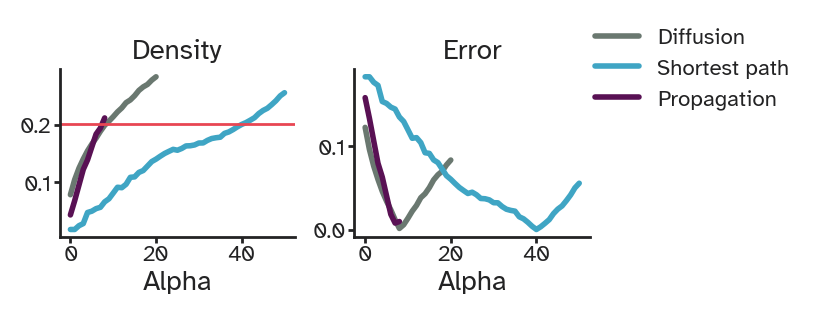

In [159]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
axes["A"].plot(rd_densities,lw=2,label="Diffusion")
axes["A"].plot(sp_densities,lw=2,color=viz_colors["colds"]["LAKE_BLUE"],label="Shortest path")
axes["A"].plot(pd_densities,lw=2,color=viz_colors["purples"]["PURPLER"],label="Propagation")
axes["A"].axhline(check_density(connectivity),color=viz_colors["warms"]["LECKER_RED"])

axes["B"].plot(rd_scores,lw=2)
axes["B"].plot(pd_scores,lw=2,color=viz_colors["purples"]["PURPLER"])
axes["B"].plot(sp_scores,lw=2,color=viz_colors["colds"]["LAKE_BLUE"])

axes["A"].set_title("Density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.legend(bbox_to_anchor=(1.3,1),frameon=False)
fig.tight_layout(w_pad=0.1)
sns.despine()
#plt.savefig("figures/res1_rd_vs_sp_vs_pd.pdf",dpi=600,bbox_inches='tight');

In [18]:
with h5py.File("simulations/rd_10k_res1_matrices.h5", "r") as f:
    best_rd = f["data"][:,:,:,np.argmin(rd_scores)]
best_rd.shape

(114, 114, 10000)

In [16]:
with h5py.File("simulations/sp_30k_res1_matrices.h5", "r") as f:
    best_sp = f["data"][:,:,:,np.argmin(sp_scores)]
best_sp.shape

(114, 114, 30000)

Text(0.5, 1.0, 'Empirical')

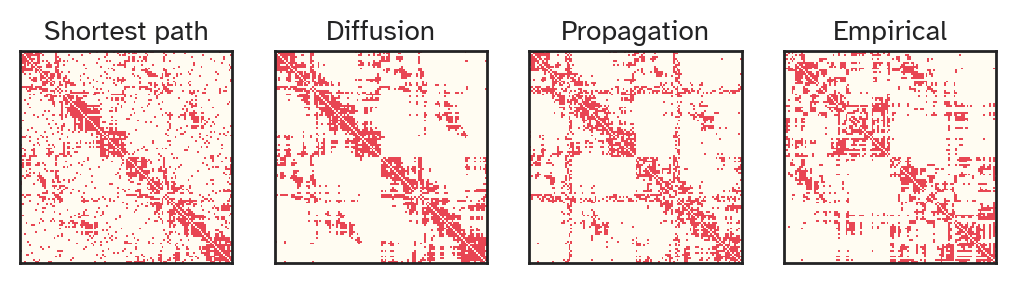

In [172]:
fig, axes = plt.subplot_mosaic([["A", "B", "C", "D"]], 
                               figsize=(viz.cm_to_inch((16,4))),
                               dpi=200)
viz.plot_matrix(best_sp[:,:,-1],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
viz.plot_matrix(best_rd[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["B"])
viz.plot_matrix(best_pd[:,:,-1], 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["C"])
viz.plot_matrix(connectivity, 
                cbar=False, sns_kwargs=sns_kwargs, axis=axes["D"])
axes["A"].set_title("Shortest path")
axes["B"].set_title("Diffusion")
axes["C"].set_title("Propagation")
axes["D"].set_title("Empirical")
#plt.savefig("figures/res1_rd_vs_sp_vs_pd_adjmats.pdf",dpi=600,bbox_inches='tight');

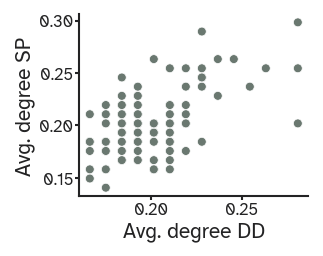

In [12]:
plt.figure(figsize=(viz.cm_to_inch((5,4))), dpi=150)
sns.scatterplot(x=best_rd[:,:,-1].mean(0), 
                y=best_sp[:,:,-1].mean(0),size=2)
plt.xlabel("Avg. degree DD")
plt.ylabel("Avg. degree SP")
plt.gca().legend().remove()
sns.despine()

Measures for now:
- rd
- Network density
- Wiring cost
- sp 
- Average clustering
- Degree assortativity
- Accuracy
- F1 score
- Endpoint similarity
- pd

Measures for later:
- Modularity
- Small-worldness
- Computational efficiency

In [142]:
MEASURE = True
if MEASURE:
    # measures_rd = np.zeros((10,best_rd.shape[2]))
    # measures_sp = np.zeros((10,best_sp.shape[2]))
    measures_pd = np.zeros((10,pd_histories.shape[2]))
    
    # for timepoint in tqdm(range(best_rd.shape[2]), desc="Diffusion"):
    #     measures_rd[0,timepoint] = gen.resistance_distance(best_rd[:,:,timepoint],coordinates).mean()
    #     measures_rd[1,timepoint] = check_density(best_rd[:,:,timepoint])
    #     measures_rd[2,timepoint] = calculate_wiring_cost(best_rd[:,:,timepoint],euclidean_dis)
    #     measures_rd[3,timepoint] = gen.shortest_path_distance(best_rd[:,:,timepoint],coordinates).mean()
    #     measures_rd[4,timepoint] = nx.average_clustering(nx.from_numpy_array(best_rd[:,:,timepoint]))
    #     measures_rd[5,timepoint] = nx.degree_assortativity_coefficient(nx.from_numpy_array(best_rd[:,:,timepoint]))
    #     measures_rd[6,timepoint], measures_rd[7,timepoint] = evaluate_adjacency(connectivity,best_rd[:,:,timepoint])
    #     measures_rd[8,timepoint] = calculate_endpoint_similarity(best_rd[:,:,timepoint],connectivity).mean()
    #     measures_rd[9,timepoint] = gen.propagation_distance(best_rd[:,:,timepoint]).mean()
    # np.save("simulations/rd_10k_res1_measures.npy",measures_rd)

    # for timepoint in tqdm(range(best_sp.shape[2]), desc="Shortest path"):
    #     measures_sp[0,timepoint] = gen.resistance_distance(best_sp[:,:,timepoint],coordinates).mean()
    #     measures_sp[1,timepoint] = check_density(best_sp[:,:,timepoint])
    #     measures_sp[2,timepoint] = calculate_wiring_cost(best_sp[:,:,timepoint],euclidean_dis)
    #     measures_sp[3,timepoint] = gen.shortest_path_distance(best_sp[:,:,timepoint],coordinates).mean()
    #     measures_sp[4,timepoint] = nx.average_clustering(nx.from_numpy_array(best_sp[:,:,timepoint]))
    #     measures_sp[5,timepoint] = nx.degree_assortativity_coefficient(nx.from_numpy_array(best_sp[:,:,timepoint]))
    #     measures_sp[6,timepoint], measures_sp[7,timepoint] = evaluate_adjacency(connectivity,best_sp[:,:,timepoint])
    #     measures_sp[8,timepoint] = calculate_endpoint_similarity(best_sp[:,:,timepoint],connectivity).mean()
    #     measures_sp[9,timepoint] = gen.propagation_distance(best_sp[:,:,timepoint]).mean()
    # np.save("simulations/sp_30k_res1_measures.npy",measures_sp)
    
    for timepoint in tqdm(range(best_pd.shape[2]), desc="Propagation"):
        measures_pd[0,timepoint] = gen.resistance_distance(best_pd[:,:,timepoint],coordinates).mean()
        measures_pd[1,timepoint] = check_density(best_pd[:,:,timepoint])
        measures_pd[2,timepoint] = calculate_wiring_cost(best_pd[:,:,timepoint],euclidean_dis)
        measures_pd[3,timepoint] = gen.shortest_path_distance(best_pd[:,:,timepoint],coordinates).mean()
        measures_pd[4,timepoint] = nx.average_clustering(nx.from_numpy_array(best_pd[:,:,timepoint]))
        measures_pd[5,timepoint] = nx.degree_assortativity_coefficient(nx.from_numpy_array(best_pd[:,:,timepoint]))
        measures_pd[6,timepoint], measures_pd[7,timepoint] = evaluate_adjacency(connectivity,best_pd[:,:,timepoint])
        measures_pd[8,timepoint] = calculate_endpoint_similarity(best_pd[:,:,timepoint],connectivity).mean()
        measures_pd[9,timepoint] = gen.propagation_distance(best_pd[:,:,timepoint]).mean()
    np.save("simulations/pd_alpha08_10k_res1_measures.npy",measures_pd)
else:
    measures_rd = np.load("simulations/rd_10k_res1_measures.npy")
    measures_sp = np.load("simulations/sp_30k_res1_measures.npy")
    measures_pd = np.load("simulations/pd_10k_res1_measures.npy")

Propagation:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
Propagation: 100%|██████████| 10000/10000 [05:17<00:00, 31.54it/s]


In [43]:
from bct import randmio_und, latmio_und

In [44]:
null_results = np.zeros((6,1000))
for sample in tqdm(range(1000), desc="Nullz"):
    shuffled_connectivity = randmio_und(connectivity, itr=10,seed=sample)[0]
    latticized_connectivity = latmio_und(connectivity, itr=10,seed=sample)[0]
    null_results[0,sample], null_results[1,sample] = evaluate_adjacency(shuffled_connectivity,connectivity)
    null_results[2,sample] = calculate_endpoint_similarity(shuffled_connectivity,connectivity).mean()
    null_results[3,sample], null_results[4,sample] = evaluate_adjacency(connectivity,latticized_connectivity)
    null_results[5,sample] = calculate_endpoint_similarity(latticized_connectivity,connectivity).mean()
np.save("simulations/null_results.npy",null_results)

Nullz:   0%|          | 0/1000 [00:00<?, ?it/s]

Nullz: 100%|██████████| 1000/1000 [11:43<00:00,  1.42it/s]


In [46]:
measures_empirical = np.zeros((7,1))
measures_empirical[0] = gen.resistance_distance(connectivity,coordinates).mean()
measures_empirical[1] = check_density(connectivity)
measures_empirical[2] = calculate_wiring_cost(connectivity,euclidean_dis)
measures_empirical[3] = gen.shortest_path_distance(connectivity,coordinates).mean()
measures_empirical[4] = nx.average_clustering(nx.from_numpy_array(connectivity))
measures_empirical[5] = nx.degree_assortativity_coefficient(nx.from_numpy_array(connectivity))
measures_empirical[6] = gen.propagation_distance(connectivity).mean()


In [48]:
import statsmodels.stats.api as sms

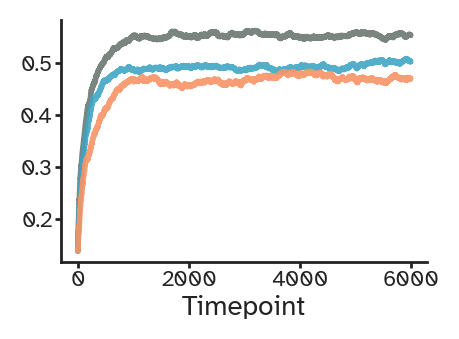

In [149]:
plt.figure(figsize=(viz.cm_to_inch((6,4))), dpi=200)
plt.plot(measures_rd[7,:6000],lw="2",alpha=0.9)
plt.plot(measures_sp[7,:6000],lw="2",alpha=0.9)
plt.plot(measures_pd[7,:6000],lw="2",alpha=0.9)

#plt.axhline(measures_empirical[4],color=viz_colors["warms"]["LECKER_RED"])
#plt.ylim(2,5)

#plt.axhspan(0,sms.DescrStatsW(null_results[0]).tconfint_mean(alpha=0.001)[1],alpha=0.2)

#plt.ylabel("Accuracy")
plt.xlabel("Timepoint")
sns.despine()
#plt.savefig("figures/res1_consensus_accuracy.pdf",dpi=600,bbox_inches='tight');


In [111]:
np.argmax(measures_pd[7,])

7965

In [109]:
evaluate_adjacency(best_sp[:,:,0],connectivity)

(81.16343490304709, 0.13802816901408452)

In [168]:
# Create parameter trajectories
n_iterations = 3_000
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, 1)
beta = np.full(n_iterations, 1)
noise = np.zeros(n_iterations)
penalty = np.zeros(n_iterations)
batch_size = np.full(n_iterations, 8)

start = 100
stop = 120
numsteps = stop - start
params = np.linspace(start, stop, numsteps)
scores = np.zeros(len(params))
histories = np.zeros((n_nodes, n_nodes, n_iterations, len(params)))
densities = np.zeros(len(params))
for ind, val in enumerate(params):
    alpha = np.full(n_iterations, val)
    histories[...,ind] = gen.simulate_network_evolution(
        coordinates=coordinates,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=np.full(n_iterations, 1),
        noise=noise,
        distance_fn=gen.topological_distance,
        connectivity_penalty=penalty,
        n_jobs=-1,
        random_seed=11,
        batch_size=batch_size,
    )
    scores[ind] = density_distance(connectivity, histories[:,:,-1,ind])
    densities[ind] = check_density(histories[:,:,-1,ind])
np.save("simulations/td_3k_res1_scores.npy",scores)
np.save("simulations/td_3k_res1_matrices.npy",histories)
np.save("simulations/td_3k_res1_densities.npy",densities)

Simulating network evolution:   0%|          | 0/2999 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debu

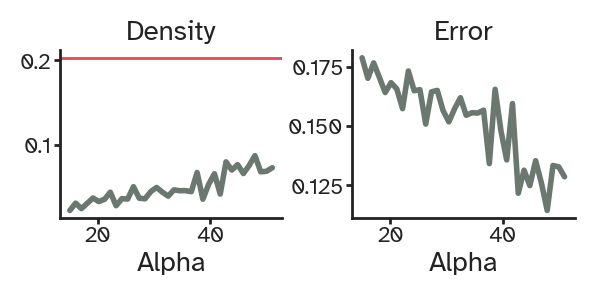

In [178]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((8,4))),
                               dpi=200,sharex=True)
axes["A"].plot(params,densities,lw=2)
axes["A"].axhline(check_density(connectivity),color=viz_colors["warms"]["LECKER_RED"])
axes["B"].plot(params,scores,lw=2)

axes["A"].set_title("Density")
axes["B"].set_title("Error")
axes["A"].set_xlabel("Alpha")
axes["B"].set_xlabel("Alpha")
fig.tight_layout(w_pad=0.7)
sns.despine()
#plt.savefig("figures/res1_rd_vs_sp.pdf",dpi=600,bbox_inches='tight');

In [170]:
np.argmin(scores), params[np.argmin(scores)], densities[np.argmin(scores)]

(32, 47.91428571428571, 0.0872535320602391)

In [189]:
n_iterations = 3_000
n_nodes = connectivity.shape[0]
alpha = np.full(n_iterations, 110)
beta = np.full(n_iterations, 1)
noise = np.zeros(n_iterations)
penalty = np.full(n_iterations, 50)
batch_size = np.full(n_iterations, 16)

binary = gen.simulate_network_evolution(
        coordinates=coordinates,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta,
        noise=noise,
        distance_fn=gen.topological_distance,
        connectivity_penalty=penalty,
        n_jobs=-1,
        random_seed=11,
        batch_size=batch_size,
    )


Simulating network evolution: 100%|██████████| 2999/2999 [02:04<00:00, 24.07it/s]


In [195]:
binary.shape[2]

3000

In [196]:
measures_td = np.zeros((8,binary.shape[2]))
for timepoint in tqdm(range(binary.shape[2]), desc="barabim baraboom"):
        measures_td[0,timepoint] = gen.shortest_path_distance(binary[:,:,timepoint],coordinates).mean()
        measures_td[1,timepoint] = check_density(binary[:,:,timepoint])
        measures_td[2,timepoint] = calculate_wiring_cost(binary[:,:,timepoint],euclidean_dis)
        measures_td[3,timepoint] = gen.resistance_distance(binary[:,:,timepoint],coordinates).mean()
        measures_td[4,timepoint] = nx.average_clustering(nx.from_numpy_array(binary[:,:,timepoint]))
        measures_td[5,timepoint] = nx.degree_assortativity_coefficient(nx.from_numpy_array(binary[:,:,timepoint]))
        measures_td[6,timepoint] = gen.topological_distance(binary[:,:,timepoint],coordinates).mean()
empirical_td = gen.topological_distance(connectivity,coordinates).mean()

barabim baraboom:   0%|          | 0/3000 [00:00<?, ?it/s]/Users/kf02/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
barabim baraboom: 100%|██████████| 3000/3000 [01:43<00:00, 28.94it/s]


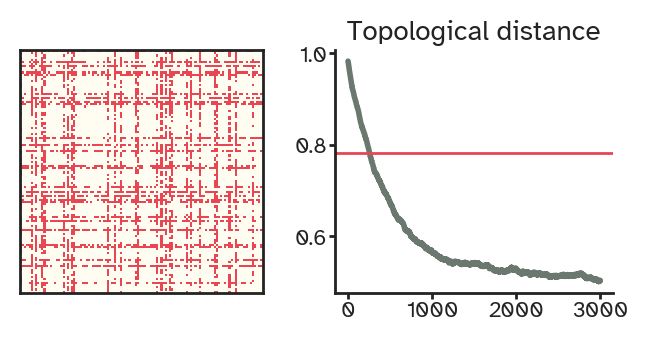

In [203]:
fig, axes = plt.subplot_mosaic([["A", "B"]], 
                               figsize=(viz.cm_to_inch((10,4))),
                               dpi=200)
viz.plot_matrix(binary[:,:,-1],
                cbar=False,sns_kwargs=sns_kwargs,axis=axes["A"])
axes["B"].plot(measures_td[6,:],lw=2)
axes["B"].axhline(empirical_td,color=viz_colors["warms"]["LECKER_RED"])

axes["B"].set_title("Topological distance")
sns.despine(ax=axes["B"])
plt.savefig("figures/res1_td.pdf",dpi=600,bbox_inches='tight');

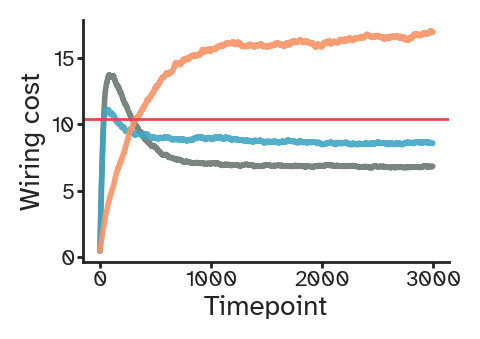

In [274]:
plt.figure(figsize=(viz.cm_to_inch((6,4))), dpi=200)
plt.plot(measures_rd[2,:3000],lw="2",alpha=0.9)
plt.plot(measures_sp[2,:3000],lw="2",alpha=0.9)
plt.plot(measures_td[2,:3000],lw="2",alpha=0.9)

plt.axhline(measures_empirical[2],color=viz_colors["warms"]["LECKER_RED"])
#plt.ylim(1.5,2.5)
plt.ylabel("Wiring cost")
plt.xlabel("Timepoint")
sns.despine()
plt.savefig("figures/res1_wiring_cost_w_td.pdf",dpi=600,bbox_inches='tight');

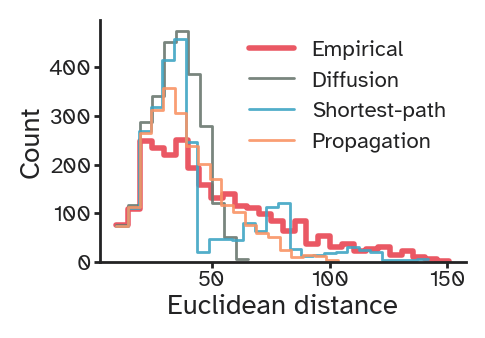

In [174]:
plt.figure(figsize=(viz.cm_to_inch((6,4))), dpi=200)
sns.histplot(euclidean_dis[connectivity],
            label='Empirical',
            lw=2,
            binwidth=5,alpha=0.9,
            color=viz_colors["warms"]["LECKER_RED"],
            element='step',
            fill=False)

sns.histplot(euclidean_dis[best_rd[:,:,-1].astype(bool)],
            lw=1,
            binwidth=5,alpha=0.9,
            label='Diffusion',
            element='step',
            fill=False)
sns.histplot(euclidean_dis[best_sp[:,:,-1].astype(bool)],
            lw=1,
            binwidth=5,alpha=0.9,
            label='Shortest-path',
            element='step',
            fill=False)
sns.histplot(euclidean_dis[best_pd[:,:,-1].astype(bool)],
            lw=1,
            binwidth=5,alpha=0.9,
            label='Propagation',
            element='step',
            fill=False)

plt.xlabel('Euclidean distance')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_ed_histplot.pdf",dpi=600,bbox_inches='tight');

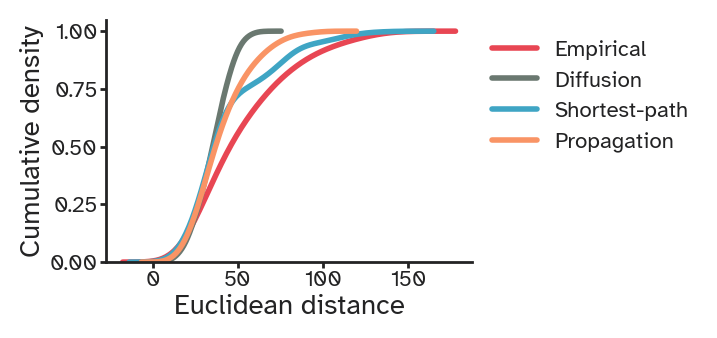

In [173]:
plt.figure(figsize=(viz.cm_to_inch((6,4))), dpi=200)
sns.kdeplot(euclidean_dis[connectivity],
            label='Empirical',
            color=viz_colors["warms"]["LECKER_RED"],lw=2,
            bw_adjust=1.5,cumulative=True)

sns.kdeplot(euclidean_dis[best_rd[:,:,-1].astype(bool)],
            label='Diffusion',lw=2,
            bw_adjust=1.5,cumulative=True)
sns.kdeplot(euclidean_dis[best_sp[:,:,-1].astype(bool)],
            label='Shortest-path',lw=2,
            bw_adjust=1.5,cumulative=True)
sns.kdeplot(euclidean_dis[best_pd[:,:,-1].astype(bool)],
            label='Propagation',lw=2,
            bw_adjust=1.5,cumulative=True)

plt.xlabel('Euclidean distance')
plt.ylabel('Cumulative density')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
sns.despine()
#plt.savefig("figures/res1_ed_cummulative_kdeplot.pdf",dpi=600,bbox_inches='tight');

In [182]:
from bct import corr_flat_und
print(corr_flat_und(connectivity,best_pd[:,:,-1]),
corr_flat_und(connectivity,best_rd[:,:,-1]),
corr_flat_und(connectivity,best_sp[:,:,-1]))

0.3300447079458656 0.43910743989950013 0.3581299756520236


In [183]:
print(corr_flat_und(best_rd[:,:,-1],best_pd[:,:,-1]),
corr_flat_und(best_sp[:,:,-1],best_rd[:,:,-1]),
corr_flat_und(best_pd[:,:,-1],best_sp[:,:,-1]))

0.620959904879015 0.6419068637068521 0.5276149454313601


In [118]:
euclidean_dis[best_rd[:,:,-1].astype(bool)].max()

65.47382568605481

In [119]:
euclidean_dis[best_sp[:,:,-1].astype(bool)].max()

141.86220362648461

In [120]:
euclidean_dis[connectivity.astype(bool)].max()

150.7584867997966

In [240]:
node_wise_rd = np.zeros((binary.shape[1],binary.shape[2]))
node_wise_sp = np.zeros((binary.shape[1],binary.shape[2]))

for timepoint in tqdm(range(binary.shape[2]), desc="barabim baraboom"):
        node_wise_rd[:,timepoint] = np.mean(best_rd[:,:,timepoint],axis=0)
        node_wise_sp[:,timepoint] = np.mean(best_sp[:,:,timepoint],axis=0)

barabim baraboom: 100%|██████████| 3000/3000 [00:00<00:00, 15433.44it/s]


In [264]:
turnover_rd = np.gradient(node_wise_rd, axis=1)
turnover_sp = np.gradient(node_wise_sp, axis=1)

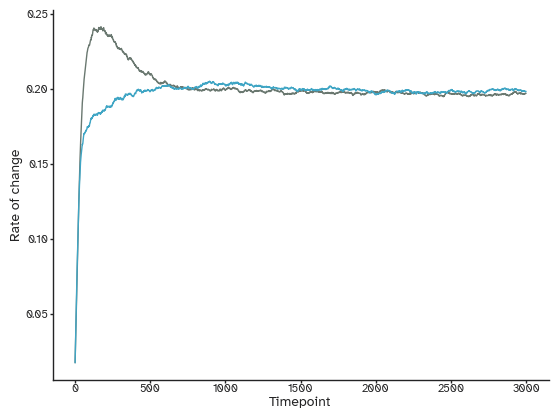

In [270]:
plt.plot(node_wise_rd.mean(0))
plt.plot(node_wise_sp.mean(0))

plt.ylabel("Rate of change")
plt.xlabel("Timepoint")
sns.despine()

# Playing with weighting schemes

In [156]:
from generative import optimize_weights

In [164]:
# Parameters
n_iterations = 100
alpha = 1.0  # Weight for distance term
beta = 0.01   # Weight for wiring cost
learning_rate = 0.01
total_weight = 1.0  # Each node has total weight of 1 to distribute

# Run optimization
weighted_history = optimize_weights(
    binary_adjacency=binary[:,:,-1],
    coordinates=coordinates,
    n_iterations=n_iterations,
    distance_fn=gen.resistance_distance,  # or your preferred distance metric
    alpha=alpha,
    beta=beta,
    total_weight=total_weight,
    learning_rate=learning_rate,
    n_jobs=-1,
)

Optimizing weights:   0%|          | 0/99 [00:00<?, ?it/s]

Optimizing weights: 100%|██████████| 99/99 [07:36<00:00,  4.61s/it]


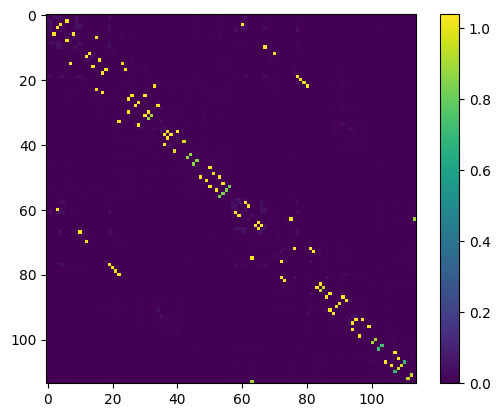

In [165]:
plt.imshow(weighted_history[:,:,-1])
plt.colorbar()

In [146]:
resdist = gen.resistance_distance(binary[:,:,-1], coordinates)
weighted = binary[:,:,-1]/euclidean_dis

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_1572/1299482811.py:2: RuntimeWarning: invalid value encountered in divide
  weighted = binary[:,:,-1]/euclidean_dis


In [149]:
empconn = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0]

/var/folders/49/t2b_h4w17d12qz0yb3dz34jm00076x/T/ipykernel_1572/3289758425.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(empconn))


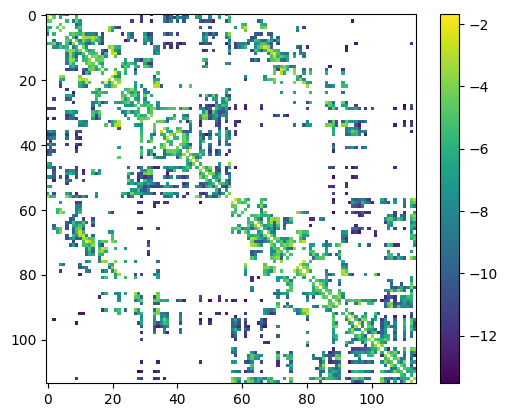

In [151]:
plt.imshow(np.log(empconn))
plt.colorbar()

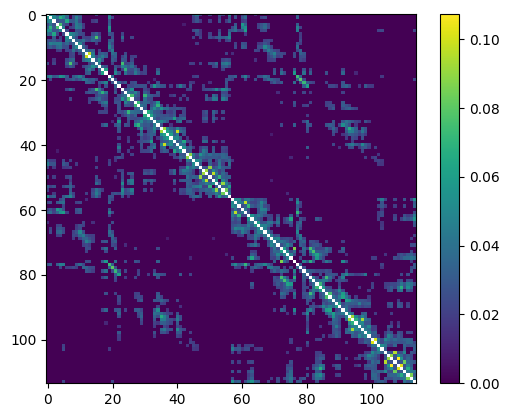

In [147]:
plt.imshow(weighted)
plt.colorbar()

<Axes: ylabel='Count'>

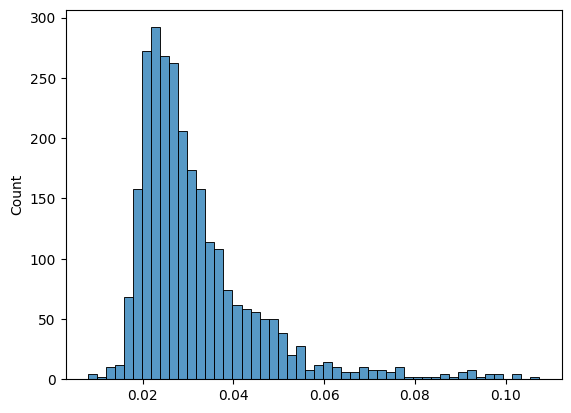

In [154]:
sns.histplot((weighted).ravel()[weighted.ravel()>0], bins=50)


In [32]:
# Vectorized correlation computation
flattened_history = history.reshape(history.shape[0] * history.shape[1], history.shape[2])
corr_matrix = np.corrcoef(flattened_history.T)


<Axes: >

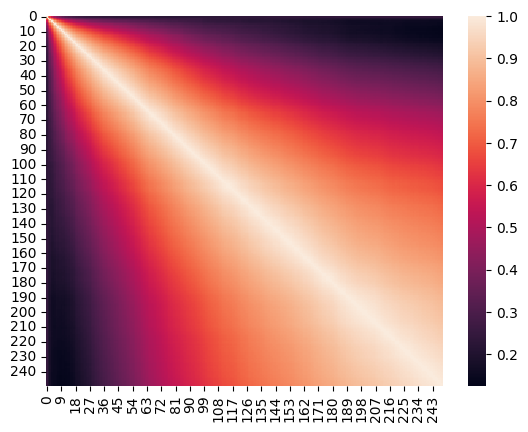

In [33]:
sns.heatmap(corr_matrix[::10,::10],vmin=corr_matrix.min(),vmax=1)

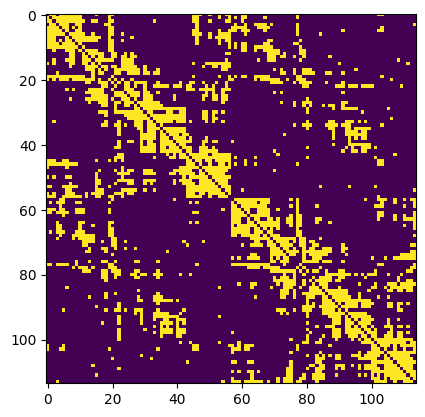

In [34]:
plt.imshow(history[:,:,-1])

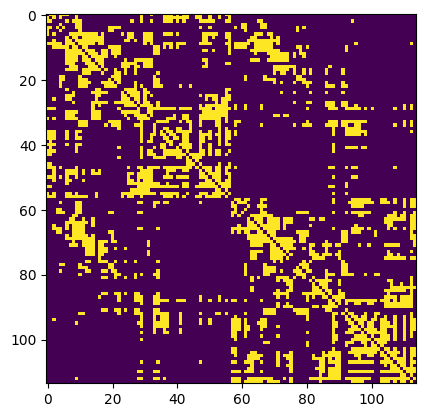

In [42]:
plt.imshow(connectivity)

In [35]:
energy_vector = np.zeros(history.shape[2])
clustering_vector = np.zeros(history.shape[2])
betweenness_vector = np.zeros(history.shape[2])
distance_vector = np.zeros(history.shape[2])
degrees_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    res = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)
    energy_vector[t] = res["energy"]
    clustering_vector[t] = res["ks_clustering"]
    betweenness_vector[t] = res["ks_betweenness"]
    distance_vector[t] = res["ks_distance"]
    degrees_vector[t] = res["ks_degrees"]

Evaluating network evolution: 100%|██████████| 2500/2500 [00:38<00:00, 64.23it/s]


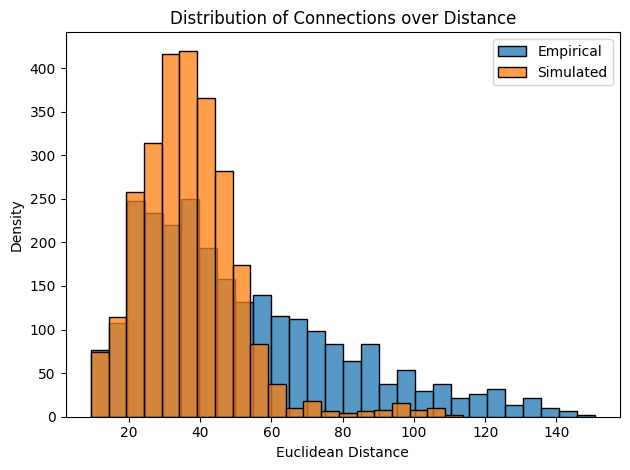

In [43]:
sns.histplot(euclidean_dis[connectivity],binwidth=5,label='Empirical')
what = history[:,:,-1].astype(bool)
sns.histplot(euclidean_dis[what],binwidth=5,label='Simulated')

plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.title('Distribution of Connections over Distance')
plt.legend()

plt.tight_layout()

In [95]:
what

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [96]:
connectivity

array([[False,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])